In [463]:
import os
from collections import Counter

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import stats
from IPython.display import Markdown
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots

%matplotlib inline

# Table of contents
1. [Sample map of incidents](#MI)
2. [General informaion about dataset](#GI)
3. [Dynamics of the number of incidents](#dynamic)
4. [Cleaning data](#cleaning)

In [2]:
df = pd.read_csv('gun-violence-data_01-2013_03-2018.csv', index_col='incident_id', parse_dates=[1])

# removing unuseful columns (mostly nans)
df.drop(labels=['address', 'incident_url', 'incident_url_fields_missing', 'congressional_district',
                'participant_name', 'sources', 'state_house_district', 'state_senate_district', 
                'participant_age_group', 'participant_relationship', 'gun_stolen'], axis=1, inplace=True)

# number of people who killed or injured
df['n_victim'] = df['n_killed'] + df['n_injured']
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['weekday'] = df['date'].dt.weekday
df['weekofyear'] = df['date'].dt.weekofyear

# Map of incidents
<a id='MI'></a>

In [67]:
temp = df[['latitude', 'longitude', 'n_killed', 'n_injured', 'n_victim', 'date']].copy().dropna()\
.sample(500, random_state=42)
temp['Outcome'] = 'No victims'
temp.loc[(temp['n_killed'] == 0) & (temp['n_injured'] > 0), 'Outcome'] = 'Only injured'
temp.loc[temp['n_killed'] > 0, 'Outcome'] = 'Killed'
temp['date'] = temp['date'].dt.date

fig = px.scatter_geo(temp, lat='latitude', lon='longitude', 
               color='Outcome', 
               color_discrete_map={'No victims': 'green', 'Only injured': 'blueviolet', 'Killed': 'red'},
               hover_data={'latitude': False, 'longitude': False, 'Outcome': False,
                           'date': True, 'n_killed': True, 'n_injured': True},
               locationmode='USA-states', scope='usa')
fig.update_layout(title={'text': 'Sample of gun related incidents in USA', 'x': 0.5})
fig.show()
fig.write_image('./images/map_of_incidents.png')

# General information about dataset
<a id='GI'></a>

In [18]:
Markdown("""
### The incidents in dataset is between {} and {}
""".format(df['date'].min().strftime('%Y-%m-%d'), df['date'].max().strftime('%Y-%m-%d')))


### The incidents in dataset is between 2013-01-01 and 2018-03-31


In [22]:
total_incidents = df.shape[0]
zero_killed_or_injured = df.loc[(df['n_killed'] == 0) & (df['n_injured']  == 0)].shape[0]

Markdown("""
### There are {} thousand incidents in {:2.0f}% of them there are injured or killed people.
""".format(total_incidents // 1000, (total_incidents - zero_killed_or_injured) * 100 / total_incidents))


### There are 239 thousand incidents in 59% of them there are injured or killed people.


In [23]:
Markdown("""
### In 1 of {:.0f} incident there is killed person and 1 of {:.0f} incident has injured person.
""".format(round(1 / df['n_killed'].mean()), round(1 / df['n_injured'].mean())))


### In 1 of 4 incident there is killed person and 1 of 2 incident has injured person.


In [24]:
temp = df['n_killed'].value_counts()\
.reset_index().rename(columns={'index': 'n_killed', 'n_killed': 'count'}).sort_values(by='n_killed')
temp['percent, %'] = 100 * temp['count'] / total_incidents
temp.loc[temp['percent, %'] >= 0.01, ['n_killed', 'percent, %']]

n_killed  percent, %
0         0   77.535600
1         1   20.208864
2         2    1.920919
3         3    0.248251
4         4    0.057995
5         5    0.017106

In [25]:
Markdown("""
### Mass shooting (more or equal than 4 killed) is rare event it happens 1 in {:.0f} inidents
""".format(100 / temp.loc[temp['n_killed'] >= 4, 'percent, %'].sum()))


### Mass shooting (more or equal than 4 killed) is rare event it happens 1 in 1158 inidents


In [26]:
temp = df['n_victim'].value_counts().reset_index()\
.rename(columns={'index': 'n_victim', 'n_victim': 'count'}).sort_values('n_victim')
temp['percent, %'] = 100 * temp['count'] / total_incidents
temp.loc[temp['percent, %'] >= 0.1, ['n_victim', 'percent, %']]

n_victim  percent, %
1         0   40.590879
0         1   48.493598
2         2    8.258615
3         3    1.779895
4         4    0.559086
5         5    0.180660

In [27]:
Markdown("""
### The most probable situation is where zero or one person injured or killed. \
Over {:.1f}% of all insidents have less than 3 injured or killed person.
""".format(temp.loc[temp['n_victim'] <= 2, 'percent, %'].sum()))


### The most probable situation is where zero or one person injured or killed. Over 97.3% of all insidents have less than 3 injured or killed person.


# Dynamics of the number of incidents
<a id='dynamic'></a>

In [205]:
temp = df.groupby(by='date')['state'].count()
temp = temp.resample('W').sum().reset_index()
temp.columns = ['date', 'num_incidents']
fig = px.line(temp, x='date', y='num_incidents', hover_data={"date": "|%B %d, %Y"})

fig.update_layout(title={'text': 'Number of incidents per week', 'x': 0.5})
fig.show()

### There is almost no data for 2013 year and it can be ignored.

In [81]:
df.drop(df.loc[df['year'] == 2013].index, axis=0, inplace=True)

In [82]:
df['year'].value_counts()

2017    61401
2016    58763
2015    53579
2014    51854
2018    13802
Name: year, dtype: int64

In [83]:
temp = df.loc[df['year'].between(2014, 2017), 'year'].value_counts()
np.polyfit(temp.index, temp.values, deg=1)

array([ 3.3825000e+03, -6.7610295e+06])

### It seems what amount of cases with guns increasing about 3400 incidents each year (if we drop 2018 because we don't have full data on them)

In [129]:
num_year = pd.DataFrame(columns=['type', 2014, 2015, 2016, 2017, 'coef'])
name = ['overall', 'no victims', 'victims']
for i, temp in enumerate([df.loc[df['year'] < 2018, 'year'].value_counts(), 
                          df.loc[(df['year'] < 2018) & (df['n_victim'] == 0), 'year'].value_counts(),
                          df.loc[(df['year'] < 2018) & (df['n_victim'] > 0), 'year'].value_counts()
                         ]):
    d = {'type': name[i]}
    coef = np.polyfit(temp.index, temp.values, deg=1)[0]
    d.update(temp)
    d.update({'coef': coef})

    num_year = num_year.append(d, ignore_index=True)

num_year['expected_grow, %'] = (100 * num_year['coef'] / num_year[2017]).apply(round)
num_year

type   2014   2015   2016   2017    coef  expected_grow, %
0     overall  51854  53579  58763  61401  3382.5                 6
1  no victims  23700  21121  22224  24272   281.9                 1
2     victims  28154  32458  36539  37129  3100.6                 8

### On average, out of 3400 new incidents, 3100 - with victims.

In [180]:
temp = df.loc[df['year'].between(2014, 2017)].pivot_table(columns='year', 
                                                   values=['n_injured', 'n_killed'], aggfunc='sum')

fig = go.Figure()
fig.add_trace(go.Scatter(x=temp.T.index, y=temp.T['n_injured'],
                    mode='lines+markers',
                    name='n_injured'))
fig.add_trace(go.Scatter(x=temp.T.index, y=temp.T['n_killed'],
                    mode='lines+markers',
                    name='n_killed'))
fig.update_layout(title={'text': 'Number of victims per year', 'x': 0.5},
                  xaxis_title='year',
                  yaxis_title='Number of victims',
                  xaxis = {'tickmode':'linear', 'tick0':2014, 'dtick':1}
        )
fig.show()
temp['coef'] = [np.polyfit(temp.columns, temp.values[i], deg=1)[0] for i in range(2)]
temp['expected_grow, %'] = (100 * temp['coef'] / temp[2017]).apply(round)
temp

year        2014   2015   2016   2017    coef  expected_grow, %
n_injured  23002  26967  30580  30703  2671.6                 9
n_killed   12557  13484  15066  15511  1044.4                 7

### The rise in incidents with both killed and injured has been rapid, but it appears to have stabilized in 2017

In [182]:
# last observation in 2018
df.loc[df['year'] == 2018, 'date'].max()

Timestamp('2018-03-31 00:00:00')

In [183]:
q1_2018 = df.loc[df['year'] == 2018, 'date'].count()
q1_2017 = df.loc[(df['year'] == 2017) & (df['month'] < 4), 'date'].count()

pd.DataFrame(data={'1_quater_2017': [q1_2017], 
                   '1_quater_2018': [q1_2018], 
                   'percent_change, %': [round(100 * (q1_2018 - q1_2017) / q1_2017)]})

1_quater_2017  1_quater_2018  percent_change, %
0          14837          13802                 -7

### The first quarter of 2018 looks promising. The number of incidents is reduced by 7%.

# Cleaning data
<a id=cleaning></a>

In [217]:
# working on participant features
for i in range(6):
    print('Part of incident with at least {1} person involved is {0}'\
          .format(round(df['participant_age'].str.split('\|+').str.get(i).str.replace('[\d]*:+', '')\
                        .notna().sum() / df['participant_age'].notna().sum(), 2), i+1))

Part of incident with at least 1 person involved is 1.0
Part of incident with at least 2 person involved is 0.34
Part of incident with at least 3 person involved is 0.1
Part of incident with at least 4 person involved is 0.03
Part of incident with at least 5 person involved is 0.01
Part of incident with at least 6 person involved is 0.0


In [218]:
# n_people is amount of people we try to extract from participant's features
# n_people <= 5 is 97% of dataset
n_people = 5
for person_number in range(n_people):
    df['age_{}'.format(person_number)] = df['participant_age'].str.split('\|+')\
    .str.get(person_number).str.replace('[\d]*:+', '')
    df['gender_{}'.format(person_number)] = df['participant_gender'].str.split('\|+')\
    .str.get(person_number).str.replace('[\d]*:+', '')

In [219]:
df['age_0'].dropna().astype('int').max(), df['age_0'].dropna().astype('int').min()

(311, 0)

In [220]:
# put restriction on age: 0 <= age <= 100
for person_number in range(n_people):
    df.loc[df['age_{}'.format(person_number)].astype('float') >= 100, 'age_{}'.format(person_number)] = 100
    df.loc[df['age_{}'.format(person_number)].astype('float') <= 0, 'age_{}'.format(person_number)] = 0

In [221]:
df['gender_0'].dropna().value_counts()

Male            177745
Female           25308
Male, female         1
Name: gender_0, dtype: int64

In [222]:
# put restriction on gender: gender is Male or Female
for person_number in range(n_people):
    df.loc[~df['gender_{}'.format(person_number)]\
           .isin(['Male', 'Female', np.NAN]), 'gender_{}'.format(person_number)] = 'Male'

In [223]:
list_noncense = ['Killed, Arrested', 'Injured, Unharmed', 'Injured, Unharmed, Arrested', 'Killed, Unharmed',
                 'Killed, Injured', 'Killed, Unharmed, Arrested']

for person_number in range(n_people):
    df['type_{}'.format(person_number)] = df['participant_type'].str.split('\|+')\
    .str.get(person_number).str.replace('[\d]*:+', '')
    df['status_{}'.format(person_number)] = df['participant_status'].str.split('\|+')\
    .str.get(person_number).str.replace('[\d]*:+', '')
    
for person_number in range(n_people):
    df.drop(df.loc[df['status_{}'.format(person_number)].isin(list_noncense)].index, axis=0, inplace=True)

In [224]:
# Some of category of incidents
description = ['Home Invasion', 'Armed robbery', 'Domestic Violence', 'Officer', 'Road rage', 'Sex crime', 
               'TSA Action', 'Car-jacking', 'Animal', 'Accidental', 'Drive-by', 'Drug involvement']

total = df['incident_characteristics'].notna().sum()
informative = df['incident_characteristics'].str.contains('|'.join(description)).sum()

Markdown("""
### There are {} description of incidents and only {} of them is useful. \
Others are something like 'Shot - Wounded/Injured' and not very informative.
""".format(total, informative))


### There are 238931 description of incidents and only 98774 of them is useful. Others are something like 'Shot - Wounded/Injured' and not very informative.


In [384]:
value = []
for desc in description:
    value.append(df['incident_characteristics'].str.contains(desc).sum())
    
fig = px.pie(values=value, names=description)
fig.show()

In [255]:
value_k = []
value_i = []

for desc in description:
    value_k.append(df.loc[df['incident_characteristics'].str.contains(desc) == True, 'n_killed'].mean())
    value_i.append(df.loc[df['incident_characteristics'].str.contains(desc) == True, 'n_injured'].mean())

fig = px.bar(pd.DataFrame({'killed': value_k, 'injured': value_i}, index=description), barmode='group', 
             color_discrete_map={'killed': 'red', 'injured': 'blue'})
fig.update_layout(title={'text': 'Average killed and injured in different situations', 'x': 0.5}, 
                  xaxis_title='Situation',
                  yaxis_title='Number of killed and injured',)
fig.show()

### The most dangerous situation are domestic violence and with involving police officer. TSA is Transportation Security Administration and mostly works in airports. This is explain why they almost doesn't have killed or injured person in their incidents.

In [410]:
value_m = []
for desc in description:
    temp = df.loc[df['incident_characteristics'].str.contains(desc) == True, :]\
    .groupby(by='month')['date'].count()
    value_m.append(temp / temp.max())
    
temp = pd.DataFrame({description[i]: series for i, series in enumerate(value_m)})
skip_list = ['Animal', 'Sex crime', 'Road rage', 'Car-jacking']
# skip_list = []
fig = px.line(temp, x=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
              y=[col for col in temp.columns if col not in skip_list])
fig.update_layout(title={'text': 'Normalized amount of incidents', 'x': 0.5}, 
                  xaxis_title='Month',
                  yaxis_title='Normalized amount of incidents',
                  legend_title_text='Incident'
                 )
fig.show()

### There isn't clear dependence, but almost all of them have maximum in January.

In [411]:
value_m = []
for desc in description:
    temp = df.loc[df['incident_characteristics'].str.contains(desc) == True, :]\
    .groupby(by='weekday')['date'].count()
    value_m.append(temp / temp.max())
    
temp = pd.DataFrame({description[i]: series for i, series in enumerate(value_m)})
skip_list = ['Animal', 'Sex crime', 'Road rage', 'Car-jacking']
# skip_list = []
fig = px.line(temp, x=['Mon', 'Tue', 'Wen', 'Thu', 'Fri', 'Sat', 'Sun'], 
              y=[col for col in temp.columns if col not in skip_list])
fig.update_layout(title={'text': 'Normalized amount of incidents', 'x': 0.5}, 
                  xaxis_title='Day of week',
                  yaxis_title='Normalized amount of incidents',
                  legend_title_text='Incident'
                 )
fig.show()

### There are some reasonable on distribution over day of week. Domestic violence happen more often on weekends when everybody home together full day long. Home invasions happen less on weekends when owners are expected.

# Work on gun_type and n_guns_involved features

In [413]:
(df['n_guns_involved'].value_counts() / df['n_guns_involved'].value_counts().sum()).head(3).sum()

0.9773100601351256

### Incidents with 3 or less gun involved are about 97% (not including NAN) of our dataset, so it is ok to extract information of this amount of gun from feature gun_type 

In [414]:
df.gun_type.isnull().sum()

99239

In [451]:
n_gun = 5
for gun in range(n_gun):
    df['gun_type_{}'.format(gun)] = df['gun_type'].str.split('\|+')\
    .str.get(gun).str.replace('[\d*]:+', '')

In [452]:
def freq_dict(df, feature_name='gun_type', n=n_gun):
    temp_dict = {}
    for gun in range(n):
        _ = df[feature_name + '_{}'.format(gun)].value_counts().to_dict()
        if len(temp_dict) == 0:
            temp_dict = _
        else:
            for (k, v) in _.items():
                if k in temp_dict:
                    temp_dict[k] += _[k]
                else:
                    temp_dict[k] = _[k] 
    return temp_dict

temp_dict = freq_dict(df)

In [453]:
temp = pd.DataFrame.from_dict(temp_dict, orient='index')\
.rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)
temp.head(15)

freq
Unknown          107709
Handgun           22017
9mm                6273
Rifle              4155
Shotgun            3829
22 LR              3241
40 SW              2665
380 Auto           2349
45 Auto            2292
38 Spl             1785
223 Rem [AR-15]    1415
12 gauge           1035
Other               997
7.62 [AK-47]        875
357 Mag             803

### There isn't information about gun type in most of incident, but we will analysis what we have.

In [468]:
suspect_gun = Counter()
victim_gun = Counter()

for i in range(5):
    temp = df.loc[(df[f'type_{i}'] == 'Subject-Suspect') & df[f'gun_type_{i}'].notna(), f'gun_type_{i}']
    suspect_gun.update(temp.value_counts().to_dict())    
    temp = df.loc[(df[f'type_{i}'] == 'Victim') & df[f'gun_type_{i}'].notna(), f'gun_type_{i}']
    victim_gun.update(temp.value_counts().to_dict())

In [483]:
temp = pd.DataFrame.from_dict(suspect_gun, orient='index')\
.rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)
temp = temp.reset_index().head(11)
temp.drop(temp.loc[(temp['index'] == 'Unknown') | (temp['index'] == '1Unknown')].index, axis=0, inplace=True)

temp2 = pd.DataFrame.from_dict(victim_gun, orient='index')\
.rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)
temp2 = temp2.reset_index().head(11)
temp2.drop(temp2.loc[(temp2['index'] == 'Unknown') | (temp2['index'] == '1Unknown')].index, axis=0, inplace=True)

fig = make_subplots(1, 2, specs=[[{'type':'domain'}, {'type':'domain'}]],
                    subplot_titles=['Shooter guns', 'Victim guns'])
fig.add_trace(go.Pie(labels=temp['index'], values=temp['freq'], name='Shooter guns'), 1, 1)
fig.add_trace(go.Pie(labels=temp2['index'], values=temp2['freq'], name='Victim guns'), 1, 2)

fig.update_layout(legend_title_text='Type of gun')
fig.show()

### The most common type of gun is handgun for both shooters and victims.

In [484]:
amount_of_killed = 4
temp_list_with_dict_k = [freq_dict(df.loc[df['n_killed'] == i]) for i in range(amount_of_killed)] \
+ [freq_dict(df.loc[df['n_killed'] >= amount_of_killed])]

temp_list_with_str_k = ['With {} dead | {} incidents'\
                      .format(i, df.loc[df['n_killed'] == i].shape[0]) for i in range(amount_of_killed)]\
+ ['With >= {} dead | {} incidents'\
   .format(amount_of_killed, df.loc[df['n_killed'] == amount_of_killed].shape[0])] 


amount_of_injured = 4
temp_list_with_dict_i = [freq_dict(df.loc[df['n_injured'] == i]) for i in range(amount_of_injured)] \
+ [freq_dict(df.loc[df['n_injured'] >= amount_of_injured])]

temp_list_with_str_i = ['With {} injured | {} incidents'\
                      .format(i, df.loc[df['n_injured'] == i].shape[0]) for i in range(amount_of_injured)]\
+ ['With >= {} injured | {} incidents'\
   .format(amount_of_injured, df.loc[df['n_injured'] == amount_of_injured].shape[0])] 

n_casulties = 4
temp_list_with_dict_c = [freq_dict(df.loc[df['n_victim'] == i]) for i in range(n_casulties)] \
+ [freq_dict(df.loc[df['n_victim'] >= n_casulties])]

temp_list_with_str_c = ['With {} killed or injured | {} incidents'\
                      .format(i, df.loc[df['n_victim'] == i].shape[0]) for i in range(n_casulties)]\
+ ['With >= {} killed or injured | {} incidents'\
   .format(n_casulties, df.loc[df['n_victim'] == n_casulties].shape[0])] 

In [485]:
# map wepon to color
temp_dict = freq_dict(df)
temp_color = pd.DataFrame.from_dict(temp_dict, orient='index')\
.rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)
temp_color = temp_color.reset_index().head(21)
temp_color.drop(temp_color.loc[(temp_color['index'] == 'Unknown') | (temp['index'] == '1Unknown')].index, 
                axis=0, inplace=True)
temp_color['color'] = (plt.cm.Set1.colors + plt.cm.Dark2.colors + plt.cm.tab10.colors)\
[:temp_color['index'].shape[0]]
temp_color.drop(['freq'], axis=1, inplace=True)

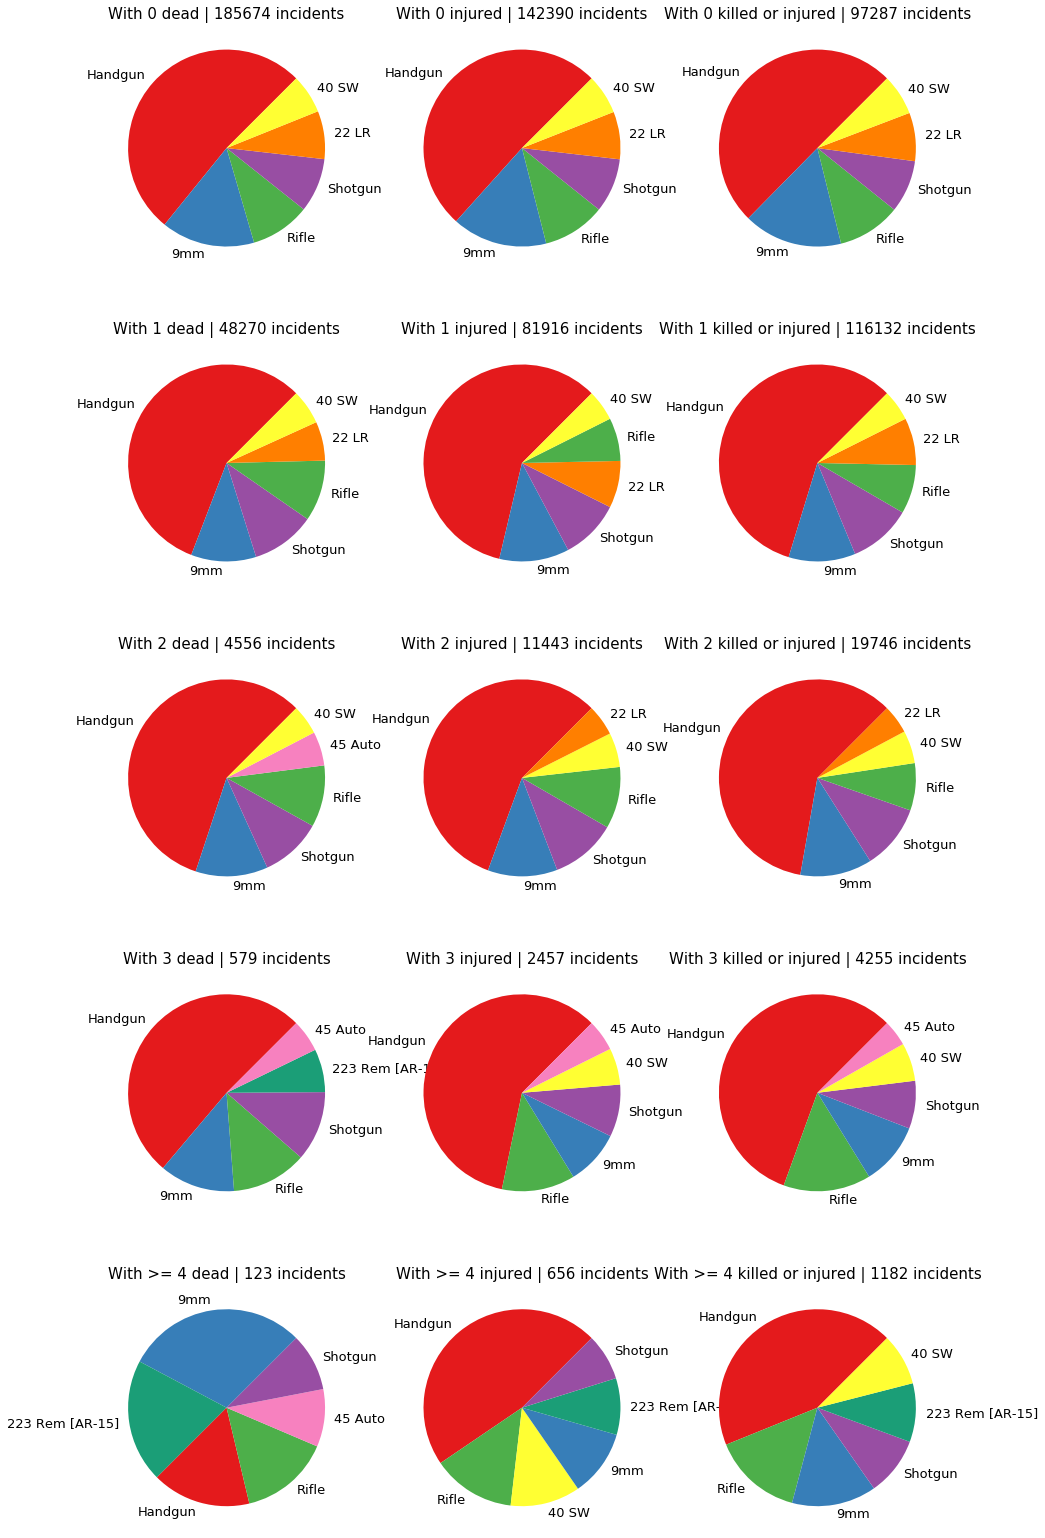

In [486]:
fig, ax = plt.subplots(len(temp_list_with_dict_k), 3)
fig.set_figheight(7 * amount_of_killed)
fig.set_figwidth(15)

for i, temp_dict in enumerate(temp_list_with_dict_k):
    temp = pd.DataFrame.from_dict(temp_dict, orient='index')\
    .rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)

    temp = temp.reset_index().head(7)
    temp.drop(temp.loc[(temp['index'] == 'Unknown') | (temp['index'] == '1Unknown')].index, axis=0, inplace=True)
    temp = temp.merge(temp_color, how='inner', on='index')
    patches, texts = ax[i, 0].pie(x=temp['freq'], labels=temp['index'], colors=temp['color'], startangle=45)
    ax[i, 0].set_title(temp_list_with_str_k[i], fontdict={'fontsize': 15})
    [text.set_fontsize(13) for text in texts];
    
for i, temp_dict in enumerate(temp_list_with_dict_i):
    temp = pd.DataFrame.from_dict(temp_dict, orient='index')\
    .rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)

    temp = temp.reset_index().head(7)
    temp.drop(temp.loc[(temp['index'] == 'Unknown') | (temp['index'] == '1Unknown')].index, axis=0, inplace=True)
    temp = temp.merge(temp_color, how='inner', on='index')
    patches, texts = ax[i, 1].pie(x=temp['freq'], labels=temp['index'], colors=temp['color'], startangle=45)
    ax[i, 1].set_title(temp_list_with_str_i[i], fontdict={'fontsize': 15})
    [text.set_fontsize(13) for text in texts];
    
for i, temp_dict in enumerate(temp_list_with_dict_c):
    temp = pd.DataFrame.from_dict(temp_dict, orient='index')\
    .rename(columns={0: 'freq'}).sort_values(by='freq', ascending=False)

    temp = temp.reset_index().head(7)
    temp.drop(temp.loc[(temp['index'] == 'Unknown') | (temp['index'] == '1Unknown')].index, axis=0, inplace=True)
    temp = temp.merge(temp_color, how='inner', on='index')
    patches, texts = ax[i, 2].pie(x=temp['freq'], labels=temp['index'], colors=temp['color'], startangle=45)
    ax[i, 2].set_title(temp_list_with_str_c[i], fontdict={'fontsize': 15})
    [text.set_fontsize(13) for text in texts];

### In mass shooting part of handguns is decreasing.

In [487]:
# There are much more male than female
freq_dict(df, 'gender', 5)

{'Male': 304648, 'Female': 42305}

In [488]:
# ratio
304734 / 42234

7.215371501633755

In [571]:
temp = np.concatenate([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Victim'), 
                              'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
counts, bins = np.histogram(temp, bins=range(0, 100, 5))
# bins = 0.5 * (bins[:-1] + bins[1:])

temp2 = np.concatenate([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Victim'), 
                              'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
counts2, bins = np.histogram(temp2, bins=range(0, 100, 5))
# bins = 0.5 * (bins[:-1] + bins[1:])
bins = bins[1:]


fig = px.bar(pd.DataFrame({'Female': counts / sum(counts), 'Male': counts2 / sum(counts2)}, index=bins), 
             barmode='group', color_discrete_map={'Female': 'blue', 'Male': 'red'},
             labels={'variable': 'Sex', 'index': 'Age', 'value': 'Prob'})
fig.update_layout(title={'text': 'Normalized histogram of victim age', 'x': 0.5}, 
                  xaxis_title='Age bucket',
                  xaxis = {'tickmode': 'linear', 'tick0':5, 'dtick':5},
                  yaxis_title='Probability density',
                  legend_title_text='Sex')
fig.show()

In [572]:
temp = np.concatenate([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Subject-Suspect'), 
                              'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
counts, bins = np.histogram(temp, bins=range(0, 100, 5))
# bins = 0.5 * (bins[:-1] + bins[1:])

temp2 = np.concatenate([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Subject-Suspect'), 
                              'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
counts2, bins = np.histogram(temp2, bins=range(0, 100, 5))
# bins = 0.5 * (bins[:-1] + bins[1:])
bins = bins[1:]


fig = px.bar(pd.DataFrame({'Female': counts / sum(counts), 'Male': counts2 / sum(counts2)}, index=bins), 
             barmode='group', color_discrete_map={'Female': 'blue', 'Male': 'red'},
             labels={'variable': 'Sex', 'index': 'Age', 'value': 'Prob'})
fig.update_layout(title={'text': 'Normalized histogram of shooter age', 'x': 0.5}, 
                  xaxis_title='Age bucket',
                  xaxis = {'tickmode': 'linear', 'tick0':5, 'dtick':5},
                  yaxis_title='Probability density',
                  legend_title_text='Sex')
fig.show()

In [533]:
temp1 = np.concatenate([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Victim'), 
                              'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
temp2 = np.concatenate([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Victim'), 
                               'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
temp3 = np.concatenate([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Subject-Suspect'), 
                              'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
temp4 = np.concatenate([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Subject-Suspect'), 
                               'age_%s' % i].dropna().apply(int).values for i in range(n_people)])


fig = go.Figure()
fig.add_trace(go.Box(y=temp1, name='Female victim', boxpoints=False))
fig.add_trace(go.Box(y=temp2, name='Male victim', boxpoints=False))
fig.add_trace(go.Box(y=temp3, name='Female shooter', boxpoints=False))
fig.add_trace(go.Box(y=temp4, name='Male shooter', boxpoints=False))
fig.update_layout(title={'text': 'Compare age distribution of different participants in incident', 'x': 0.5}, 
                  xaxis_title='Role',
                  yaxis_title='Age',
                  showlegend=False)

fig.show()

### The difference between the age composition of the victim / shooter is small. Men become involved in firearms incidents before women.

In [577]:
# more precise analysis about young people

start_age = 15
end_age = 40
temp = np.concatenate([df.loc[(df['gender_%s' % i] == 'Female') & (df['type_%s' % i] == 'Subject-Suspect'), 
                              'age_%s' % i].dropna().apply(int).values for i in range(n_people)])
temp2 = np.concatenate([df.loc[(df['gender_%s' % i] == 'Male') & (df['type_%s' % i] == 'Subject-Suspect'), 
                               'age_%s' % i].dropna().apply(int).values for i in range(n_people)])

counts, bins = np.histogram(temp, bins=range(0, 100))
counts2, bins = np.histogram(temp2, bins=range(0, 100))
bins = bins[start_age:end_age+1]

counts = counts / counts.sum()
counts2 = counts2 / counts2.sum()

counts = counts[start_age:end_age+1]
counts2 = counts2[start_age:end_age+1]

fig = px.bar(pd.DataFrame({'Female': counts, 'Male': counts2}, index=bins), 
             barmode='group', color_discrete_map={'Female': 'blue', 'Male': 'red'}, 
             labels={'variable': 'Sex', 'index': 'Age', 'value': 'Prob'})
fig.update_layout(title={'text': 'Distribution of shooter with age between 15 and 40', 'x': 0.5}, 
                  xaxis_title='Age',
                  xaxis = {'tickmode': 'linear', 'tick0':15, 'dtick':1},
                  yaxis_title='Probability density',
                  legend_title_text='Sex')
fig.show()

### From graph it's clear that distributions for male and female are different. Peak of incidents with male at 18-19 years old and then declining. Peak of incidents with female at 23 years old and then slowly declining.

In [578]:
df['status_0'].value_counts()

Injured               85770
Killed                50651
Unharmed, Arrested    35174
Unharmed              34428
Arrested               3819
Injured, Arrested      1789
Name: status_0, dtype: int64

In [579]:
status_k = ['Killed']
status_i = ['Injured', 'Injured, Arrested']
status_u = ['Unharmed, Arrested', 'Unharmed', 'Arrested']

def frequency_incidents(df, gender, rolle, status_group, n_people=n_people):
    return sum([df.loc[(df['gender_%s' % i] == gender) & (df['type_%s' % i] == rolle) & \
                         (df['status_%s' % i].isin(status_group)), 'n_victim'].shape[0] \
                for i in range(n_people)])

In [587]:
temp_f_k_v = frequency_incidents(df, 'Female', 'Victim', status_k)
temp_m_k_v = frequency_incidents(df, 'Male', 'Victim', status_k)
temp_f_i_v = frequency_incidents(df, 'Female', 'Victim', status_i)
temp_m_i_v = frequency_incidents(df, 'Male', 'Victim', status_i)
temp_f_u_v = frequency_incidents(df, 'Female', 'Victim', status_u)
temp_m_u_v = frequency_incidents(df, 'Male', 'Victim', status_u)

temp_f_k_s = frequency_incidents(df, 'Female', 'Subject-Suspect', status_k)
temp_m_k_s = frequency_incidents(df, 'Male', 'Subject-Suspect', status_k)
temp_f_i_s = frequency_incidents(df, 'Female', 'Subject-Suspect', status_i)
temp_m_i_s = frequency_incidents(df, 'Male', 'Subject-Suspect', status_i)
temp_f_u_s = frequency_incidents(df, 'Female', 'Subject-Suspect', status_u)
temp_m_u_s = frequency_incidents(df, 'Male', 'Subject-Suspect', status_u)

f_total_v = sum([temp_f_k_v, temp_f_i_v, temp_f_u_v])
f_total_s = sum([temp_f_k_s, temp_f_i_s, temp_f_u_s])
m_total_v = sum([temp_m_k_v, temp_m_i_v, temp_m_u_v])
m_total_s = sum([temp_m_k_s, temp_m_i_s, temp_m_u_s])

In [603]:
x = [['Victim', 'Victim', 'Victim', 'Shooter', 'Shooter', 'Shooter'],
    ['killed', 'injured', 'unharmed', 'killed', 'injured', 'unharmed']]

fig = go.Figure()
fig.add_bar(x=x, y=[temp_f_k_v / f_total_v, temp_f_i_v / f_total_v, temp_f_u_v / f_total_v, 
                    temp_f_k_s / f_total_s, temp_f_i_s / f_total_s, temp_f_u_s / f_total_s], 
            name='Female')
fig.add_bar(x=x, y=[temp_m_k_v / m_total_v, temp_m_i_v / m_total_v, temp_m_u_v / m_total_v, 
                    temp_m_k_s / m_total_s, temp_m_i_s / m_total_s, temp_m_u_s / m_total_s], 
            name='Male')
fig.update_layout(title={'text': 'Probability of outcome normalized by sex and role', 'x': 0.5},
                  yaxis_title='Probability', legend_title_text='Sex', 
                  barmode='group')
fig.show()

### The distribution between gender is pretty similar.

In [620]:
week = df['weekday'].value_counts().reset_index().rename(columns={'index': 'weekday', 'weekday': 'count'})

fig = px.bar(week, x='weekday', y='count')
fig.update_layout(title={'text': 'Number of incidents per day', 'x': 0.5},
                  yaxis_title='Number of incidents', xaxis_title_text='Day of week',
                  xaxis = {'tickmode': 'array', 
                           'tickvals': np.arange(0, 7),
                           'ticktext': ['Mon', 'Tue', 'Wen', 'Thu', 'Fri', 'Sat', 'Sun'],
                          }
                  )
fig.show()

### There is a little bit more incidents on weekends. Let's use statistical test to know that this is not random noise.

In [621]:
temp = df.groupby(by=['year', 'weekofyear', 'weekday'])['date'].count()
temp = temp.reset_index().rename(columns={'date': 'count'})
day_list = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

In [625]:
# test distribution of number of incidents for each weekday for normality
for day in range(0, 7):
    print('Day: {} shapiro test for normality: {}'\
          .format(day, stats.shapiro(temp.loc[temp['weekday'] == day, 'count'])))

Day: 0 shapiro test for normality: ShapiroResult(statistic=0.9825578927993774, pvalue=0.007912449538707733)
Day: 1 shapiro test for normality: ShapiroResult(statistic=0.9911661744117737, pvalue=0.20581695437431335)
Day: 2 shapiro test for normality: ShapiroResult(statistic=0.9113268852233887, pvalue=3.3482522310279705e-10)
Day: 3 shapiro test for normality: ShapiroResult(statistic=0.9927433729171753, pvalue=0.34670743346214294)
Day: 4 shapiro test for normality: ShapiroResult(statistic=0.9957313537597656, pvalue=0.8001153469085693)
Day: 5 shapiro test for normality: ShapiroResult(statistic=0.9949416518211365, pvalue=0.6702051162719727)
Day: 6 shapiro test for normality: ShapiroResult(statistic=0.8001105189323425, pvalue=4.43149956190676e-16)


In [626]:
# Check that standard deviations of the groups are equal
for day in range(7):
    print('For day #{} mean is {} and std is {}'.format(day, temp.loc[temp['weekday'] == day, 'count'].mean(), 
                    temp.loc[temp['weekday'] == day, 'count'].std()))

For day #0 mean is 152.54298642533936 and std is 24.05342931787098
For day #1 mean is 151.8584474885845 and std is 24.508434409641094
For day #2 mean is 154.1945701357466 and std is 26.895304886318232
For day #3 mean is 146.46396396396398 and std is 22.4981861221305
For day #4 mean is 148.1266968325792 and std is 21.792664788523332
For day #5 mean is 162.2117117117117 and std is 25.643840567429354
For day #6 mean is 167.95 and std is 35.86736411027688


### Sample is not perfectly normal and std of sunday is pretty different. We will use Kruskal–Wallis test instead of ANOVA because is required only independence of data and more conservative.

In [60]:
stats.kruskal(*[temp.loc[temp['weekday'] == day, 'count'] for day in range(0, 7)])

KruskalResult(statistic=101.40126172777717, pvalue=1.2797346322677868e-19)

### It appears that hypothesis of equal means is very unlikely. Let's use t-test to compare average amount of incident of Wednesday and Saturday. Wednesday has biggest average amount of incidents within weekday and Saturday has smallest average amount of incidents within weekend.

In [641]:
stats.ttest_ind(temp.loc[temp['weekday'] == 2, 'count'], temp.loc[temp['weekday'] == 5, 'count'])

Ttest_indResult(statistic=-3.210979856268291, pvalue=0.0014195792380124641)

### Hypothesis of equal means can be rejected on significant level 1%.

In [667]:
fig = plotly.subplots.make_subplots(rows=2, cols=2,
    specs=[[{"type": "bar"}, {"type": "bar"}], [{"type": "bar"}, {"type": "bar"}]],
                                   subplot_titles=[2014, 2015, 2016, 2017])

for i, year in enumerate([2014, 2015, 2016, 2017]):
    month = df.loc[df['year'] == year, 'month'].value_counts()\
    .reset_index().rename(columns={'index': 'month', 'month': 'count'})
    month = month.sort_values(by='month')
    
    fig.add_trace(
    go.Bar(x=['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], 
           y=month['count'], showlegend=False),
    row=(i // 2) + 1, col=(i % 2)+1)

for i in range(4):
    fig.update_xaxes(title_text='month', row=(i // 2) + 1, col=(i % 2)+1)
    fig.update_yaxes(title_text='count', row=(i // 2) + 1, col=(i % 2)+1)
    
fig.update_layout(title={'text': 'Number of incidents per month', 'x': 0.5}, height=600)
fig.show()

### There isn't a clear dependence. It seems that there are more incidents during summer, but it's not true about 2017. January has bigger amount of incidents than February. It can be because of holidays. 

In [668]:
calendar = pd.DataFrame(data=pd.date_range(start='2013-12-29', end='2018-12-29', freq='d'), columns=['date'])

calendar['year'] = calendar['date'].dt.year
calendar['month'] = calendar['date'].dt.month
calendar['day'] = calendar['date'].dt.day
calendar['day_of_week'] = calendar['date'].dt.day_name()
calendar['nth_day'] = calendar[['year', 'month', 'day_of_week', 'date']]\
.groupby(['year', 'month', 'day_of_week']).rank()

holiday_names = ['New Years Day', 'Martin Luther King Jr. Day', 'President\'s Day', 'Memorial Day', 
                 'Independence Day', 'Labor Day', 'Colombus Day', 'Veterans Day', 'Thanksgiving', 'Christmas Day']

# New Years Day
holiday_NY = calendar.loc[(calendar['month'] == 1) & (calendar['day'] == 1), 'date'].tolist()

# Martin Luther King Jr. Day
holiday_MLK = calendar.loc[(calendar['month'] == 1) & (calendar['day_of_week'] == 'Monday') 
                           & (calendar['nth_day'] == 3), 'date'].tolist()

# President day
holiday_PD = calendar.loc[(calendar['month'] == 2) & (calendar['day_of_week'] == 'Monday') 
                          & (calendar['nth_day'] == 3), 'date'].tolist()

# Memorial Day
holiday_MD = calendar.loc[(calendar['month'] == 5) & (calendar['day_of_week'] == 'Monday'), 
             ['date', 'year']].groupby('year').last()['date'].tolist()

# Independence Day
holiday_ID = calendar.loc[(calendar['month'] == 7) & (calendar['day'] == 4), 'date'].tolist()

# Labor Day
holiday_LD = calendar.loc[(calendar['month'] == 9) & (calendar['day_of_week'] == 'Monday') 
                           & (calendar['nth_day'] == 1), 'date'].tolist()

# Colombus Day
holiday_CD = calendar.loc[(calendar['month'] == 10) & (calendar['day_of_week'] == 'Monday') 
                           & (calendar['nth_day'] == 2), 'date'].tolist()

# Veterans Day
holiday_VD = calendar.loc[(calendar['month'] == 11) & (calendar['day'] == 11), 'date'].tolist()

# Thanksgiving
holiday_TH = calendar.loc[(calendar['month'] == 11) & (calendar['day_of_week'] == 'Thursday') 
                           & (calendar['nth_day'] == 4), 'date'].tolist()

# Christmas Day
holiday_CHR = calendar.loc[(calendar['month'] == 12) & (calendar['day'] == 25), 'date'].tolist()

In [669]:
def holiday_vs_casual(df, stat):
    temp_diff = []

    for holiday in [holiday_NY, holiday_MLK, holiday_PD, holiday_MD, holiday_ID, 
                         holiday_LD, holiday_CD, holiday_VD, holiday_TH, holiday_CHR]:
        temp = []
        for day in holiday:
            dates_h = pd.date_range(pd.to_datetime(day) - pd.to_timedelta('1 days'), 
                                    pd.to_datetime(day) + pd.to_timedelta('1 days'), freq='D')

            dates = pd.date_range(pd.to_datetime(day) + pd.to_timedelta('2 days'), 
                                  pd.to_datetime(day) + pd.to_timedelta('4 days'), freq='D')\
            .append(pd.date_range(pd.to_datetime(day) - pd.to_timedelta('4 days'), 
                                  pd.to_datetime(day) - pd.to_timedelta('2 days'), freq='D'))
            
            if stat == 'count':
                temp.append((df.loc[df['date'].isin(dates_h), 'date'].value_counts().sum() / 3)\
                            - (df.loc[df['date'].isin(dates), 'date'].value_counts().sum() / 6))
            if stat == 'injured':
                temp.append((df.loc[df['date'].isin(dates_h), 'n_injured'].sum() / 3)\
                            - (df.loc[df['date'].isin(dates), 'n_injured'].sum() / 6))
            if stat == 'killed':
                temp.append((df.loc[df['date'].isin(dates_h), 'n_killed'].sum() / 3)\
                            - (df.loc[df['date'].isin(dates), 'n_killed'].sum() / 6))

        temp_diff.append(np.array(temp).mean(axis=0))
    return temp_diff

In [670]:
h_t = holiday_vs_casual(df, 'count')
h_k = holiday_vs_casual(df, 'killed')
h_i = holiday_vs_casual(df, 'injured')

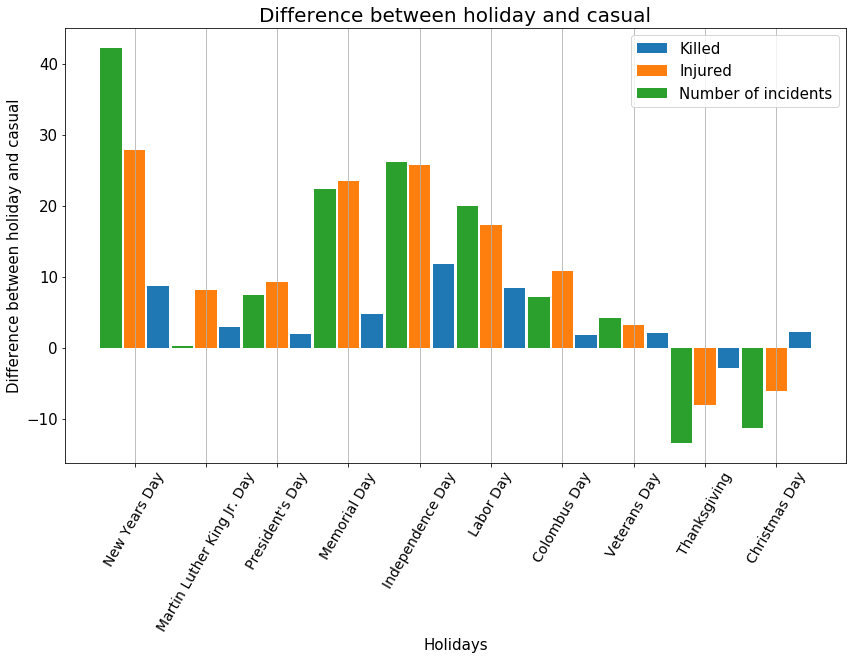

In [671]:
fig = plt.figure(figsize=(14, 8))
ax = plt.axes()
plt.bar(np.arange(len(h_k)) + 0.33, h_k, width=0.3, label='Killed')
plt.bar(np.arange(len(h_k)) - 0, h_i, width=0.3, label='Injured')
plt.bar(np.arange(len(h_k)) - 0.33, h_t, width=0.3, label='Number of incidents')
plt.legend(fontsize=15)
plt.title('Difference between holiday and casual', fontdict={'fontsize' : 20})

ax.xaxis.set_major_locator(ticker.FixedLocator((np.arange(len(h_k)))))
ax.xaxis.set_major_formatter(ticker.FixedFormatter((holiday_names)))
plt.setp(ax.xaxis.get_majorticklabels(), rotation=60, fontsize=14)
plt.yticks(fontsize=15)
plt.xlabel('Holidays', fontsize=15)
plt.ylabel('Difference between holiday and casual', fontsize=15);
ax.xaxis.grid()

### There are increment of gun violence on holidays. Let's consider amount of killed and injured. There are more of them on New Year, Memorial, Independence and Labor Days than on casual days. And reducing on Christmas and Thanksgiving.

In [673]:
# population for July 1 2016 
# Source: U.S. Census Bureau, Population Division
state_pop = pd.read_excel('nst-est2016-01.xlsx', skiprows=3, usecols=[0, 9], engine='openpyxl')\
.rename(columns={2016: 'population', 'Unnamed: 0': 'state'})
state_pop['state'] = state_pop['state'].str.replace('.', '')
state_pop.head()

state   population
0  United States  323127513.0
1      Northeast   56209510.0
2        Midwest   67941429.0
3          South  122319574.0
4           West   76657000.0

In [674]:
def state_stats(df, year=None):
    # Make a table with state's statistic each year
    if year:
        df = df.loc[df['year'] == year]
    
    temp = df.reset_index().groupby(by=['state'])\
    .agg({'n_killed': 'sum', 'n_injured': 'sum', 'n_victim': 'sum', 'incident_id': 'count'})\
    .sort_values(by='n_killed', ascending=False).reset_index().rename(columns={'incident_id': 'count_incidents'})

    temp['avg_killed'] = temp['n_killed'] / temp['count_incidents']
    temp['avg_injured'] = temp['n_injured'] / temp['count_incidents']

    temp = temp.merge(state_pop)

    # density of something on 100000 people 
    temp['den_killed'] = temp['n_killed'] * 100000 / temp['population']
    temp['den_injured'] = temp['n_injured'] * 100000  / temp['population']
    temp['den_both'] = temp['n_victim'] * 100000  / temp['population']
    
    return temp

In [675]:
df_state = state_stats(df)
df_state.head()

state  n_killed  n_injured  n_victim  count_incidents  avg_killed  \
0  California      5490       7496     12986            16245    0.337950   
1       Texas      5011       6060     11071            13556    0.369652   
2     Florida      3884       7033     10917            15013    0.258709   
3    Illinois      3388      13421     16809            17524    0.193335   
4        Ohio      2488       5665      8153            10223    0.243373   

   avg_injured  population  den_killed  den_injured    den_both  
0     0.461434  39250017.0   13.987255    19.098081   33.085336  
1     0.447035  27862596.0   17.984685    21.749589   39.734273  
2     0.468461  20612439.0   18.842991    34.120174   52.963165  
3     0.765864  12801539.0   26.465568   104.838957  131.304525  
4     0.554143  11614373.0   21.421733    48.775771   70.197504

In [676]:
def state_rank(df, stat_rank, asc, top=10):
    # Rank states for column stat_rank
    temp = df.sort_values(by=stat_rank, ascending=asc)[:top]['state'].reset_index().reset_index()
    temp['place'] = temp['level_0'] + 1
    temp = temp[['state', 'place']]
    
    return temp

In [677]:
# Rank states for columns, such as average amount of killed in incident and e.t.c.
top = 10

largest_avg_killed = state_rank(df_state, 'avg_killed', False, top)
largest_den_killed = state_rank(df_state, 'den_killed', False, top)

smallest_avg_killed = state_rank(df_state, 'avg_killed', True, top)
smallest_den_killed = state_rank(df_state, 'den_killed', True, top)

In [678]:
# State's coordinates
coordinate = pd.read_csv('state.csv')

largest_avg_killed = largest_avg_killed.merge(coordinate)
largest_den_killed = largest_den_killed.merge(coordinate)

smallest_avg_killed = smallest_avg_killed.merge(coordinate)
smallest_den_killed = smallest_den_killed.merge(coordinate)

In [710]:
fig = go.Figure(data=go.Choropleth(locations=largest_avg_killed['abbreviation'],
                                   z=largest_avg_killed['place'],
#     mode='text',
#         hoverinfo = 'text',
        text = coordinate['abbreviation'],
    locationmode = 'USA-states', # set of locations match entries in `locations`
    colorscale = 'Reds',
#     colorbar_title = "Millions USD",
))

fig.update_layout(
    title_text = '2011 US Agriculture Exports by State',
    geo_scope='usa', # limite map scope to USA
)

# fig = px.scatter_geo(coordinate, lat='latitude', lon='longitude',
# #         mode = 'text',
# #         hoverinfo = 'none',
#         text = 'abbreviation',
# #         name = 'State\'s abbreviations' ,
# #                color='Outcome', 
# #                color_discrete_map={'No victims': 'green', 'Only injured': 'blueviolet', 'Killed': 'red'},
# #                hover_data={'latitude': False, 'longitude': False, 'Outcome': False,
# #                            'date': True, 'n_killed': True, 'n_injured': True},
#                locationmode='USA-states', scope='usa')
# fig.update_layout(title={'text': 'Sample of gun related incidents in USA', 'x': 0.5})
fig.show()

In [738]:
largest_avg_killed

state  place   latitude   longitude abbreviation
0      Arizona      1  34.209964 -111.602401           AZ
1       Nevada      2  39.331093 -116.615147           NV
2        Texas      3  31.434703  -99.281824           TX
3      Alabama      4  32.739632  -86.843459           AL
4   California      5  37.148573 -119.540651           CA
5  Mississippi      6  32.686466  -89.656149           MS
6     Missouri      7  38.350750  -92.456783           MO
7   New Mexico      8  34.439127 -106.126151           NM
8     Maryland      9  38.946658  -76.674494           MD
9      Georgia     10  32.629384  -83.423213           GA

In [749]:
colors = ['red', 'orange', 'green', 'blue']
names = ['Largest average<br>amount of killed', 'Largest density<br>of killed', 
         'Smallest average<br>amount of killed', 'Smallest density<br>of killed']

# to see overlapping one
lon_bias = [0.25, -0.15, 0.15, -0.15]
fig = go.Figure()

for i, datafrrame in enumerate([largest_avg_killed, largest_den_killed, 
                                smallest_avg_killed, smallest_den_killed]):
    df_sub = datafrrame
    fig = fig.add_trace(go.Scattergeo(
        lon=df_sub['longitude'] + lon_bias[i],
        lat=df_sub['latitude'],
        hoverinfo = 'text',
        text = df_sub['state'] + ' has rank ' + df_sub['place'].astype('str'),
        marker = dict(
            size = 8,
            color = colors[i],
            sizemode = 'area'
        ),
        name = names[i],
    locationmode = 'USA-states',
))

fig.update_layout(
    title={'text': 'State and their ranks in different groups<br>(Hover to see state\'s name and rank)', 'x': 0.5},
    geo_scope='usa'
)
fig.show()

In [750]:
# Build table with states' ranks with largetest average killed in incident and density of killed on 100000 people
smallest = False
for i, stat in enumerate(['avg_killed', 'den_killed']):
    for year in range(2014, 2018):
        temp = state_stats(df, year)
        temp = state_rank(temp, stat, smallest, 51).rename(columns={'place': stat[:5] + '_' + str(year)})
        if year == 2014 and i == 0:
            prev = temp.copy()
            continue
        else:
            prev = prev.merge(temp, on='state')

# Make table with changes of ranks in years. Columns for 2014 is initial rank 
changes = prev.copy()
for stat in ['avg_k', 'den_k']:
    for year in range(2015, 2018):
        changes[stat + '_' + str(year)] = changes[stat + '_' + str(year)] - prev[stat + '_' + str(year-1)]

changes.head(5)

state  avg_k_2014  avg_k_2015  avg_k_2016  avg_k_2017  den_k_2014  \
0      Nevada           1           3          -1          -1          10   
1     Arizona           2          -1           0           0          29   
2  California           3           0           3           3          27   
3       Texas           4           1           0          -2          22   
4    Missouri           5           7          -4          -3           6   

   den_k_2015  den_k_2016  den_k_2017  
0          -1           2           1  
1           3          -4          -1  
2           8          -2          -2  
3           0           1           3  
4          -2           2          -1

In [751]:
# Build table with states' ranks with smallest average killed in incident and density of killed on 100000 people
smallest = True
for i, stat in enumerate(['avg_killed', 'den_killed']):
    for year in range(2014, 2018):
        temp = state_stats(df, year)
        temp = state_rank(temp, stat, smallest, 51).rename(columns={'place': stat[:5] + '_' + str(year)})
        if year == 2014 and i == 0:
            prev = temp.copy()
            continue
        else:
            prev = prev.merge(temp, on='state')

# Make table with changes of ranks in years. Columns for 2014 is initial rank 
changes = prev.copy()
for stat in ['avg_k', 'den_k']:
    for year in range(2015, 2018):
        changes[stat + '_' + str(year)] = changes[stat + '_' + str(year)] - prev[stat + '_' + str(year-1)]

changes.head(5)

state  avg_k_2014  avg_k_2015  avg_k_2016  avg_k_2017  den_k_2014  \
0   Rhode Island           1           0           0           0           6   
1  New Hampshire           2           2          -1           4           4   
2       Delaware           3           7          -2           5          43   
3  Massachusetts           4          -2           0           0           2   
4        Vermont           5           1           3           3          20   

   den_k_2015  den_k_2016  den_k_2017  
0          -4          -1           1  
1           0          -1           2  
2          -1         -14           5  
3           1           1           3  
4         -14           2          -5

### There are some stable states, such as Rhode Island. But mostly there aren't any monotonic changes in states' ranks.

In [759]:
df_state = state_stats(df, year=2017).merge(coordinate)

fig = go.Figure(
    data=go.Choropleth(locations=df_state['abbreviation'],
                       z=df_state['den_killed'],
                       text = df_state['state'],
                       locationmode = 'USA-states', 
                       colorscale = 'Jet',
                       marker = dict(
                           line = dict(
                               color = 'rgb(255,255,255)',
                               width = 2
                           )),
                       colorbar = dict(title = 'Number of killed')
                      ) 
)

fig.update_layout(title={'text': 'Density map of killed on 100000 people', 'x': 0.5},
    geo_scope='usa', 
)

fig.show()

In [760]:
df_state = state_stats(df, year=2017).merge(coordinate)

fig = go.Figure(
    data=go.Choropleth(locations=df_state['abbreviation'],
                       z=df_state['avg_killed'],
                       text = df_state['state'],
                       locationmode = 'USA-states', 
                       colorscale = 'Jet',
                       marker = dict(
                           line = dict(
                               color = 'rgb(255,255,255)',
                               width = 2
                           )),
                       colorbar = dict(title = 'Number of killed')
                      ) 
)

fig.update_layout(title={'text': 'Average number of killed in incident', 'x': 0.5},
    geo_scope='usa', 
)

fig.show()

### It appears that if you are involved in incident with gun the west and south states are most dangerous. Nevertheless in density perspective western states not so bad.

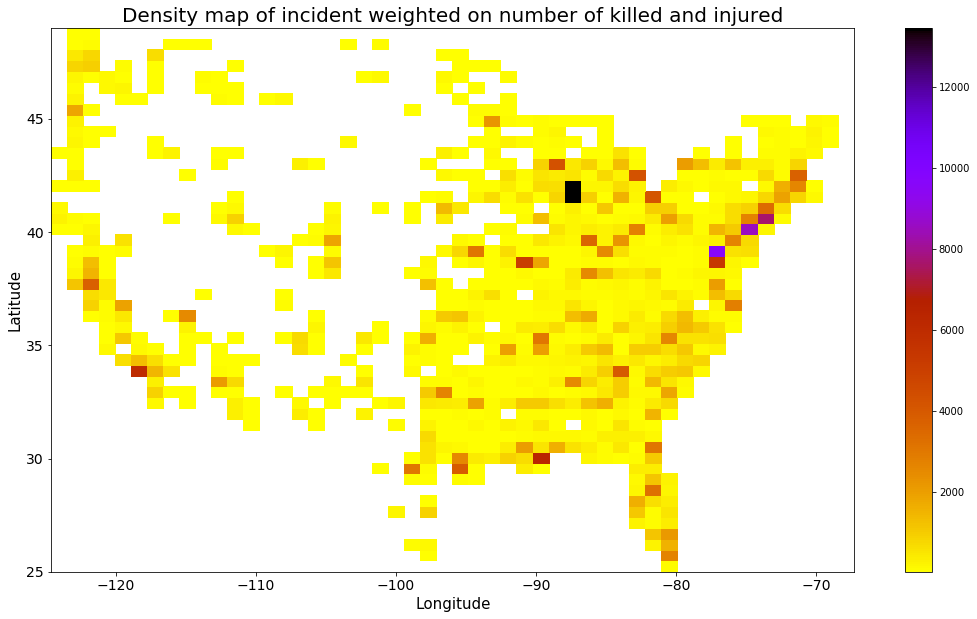

In [80]:
fig = plt.figure(figsize=(18, 10))

temp2 = df.loc[df['longitude'].between(-125, -40) & df['latitude'].between(25, 50), :]
plt.hist2d(temp2['longitude'].dropna(), temp2['latitude'].dropna(), cmin=20,
           weights=temp2['n_victim'].values + 1, 
           bins=50, cmap='gnuplot_r')
plt.colorbar()
plt.xlabel('Longitude', fontsize=15)
plt.ylabel('Latitude', fontsize=15)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.title('Density map of incident weighted on number of killed and injured', fontsize=20);

### There are spots on a map with very high amount of incident, let's consider city level. Maybe some of them made something to decrease amount of incident.

In [81]:
def city_stats(df, year=None):
    # Make a table with city's statistic each year
    if year:
        df = df.loc[df['year'] == year]
    
    temp = df.reset_index().groupby(by=['city_or_county'])\
    .agg({'n_killed': 'sum', 'n_injured': 'sum', 'n_victim': 'sum', 'incident_id': 'count'})\
    .sort_values(by='n_killed', ascending=False).reset_index().rename(columns={'incident_id': 'count_incidents'})

    temp['avg_killed'] = temp['n_killed'] / temp['count_incidents']
    temp['avg_injured'] = temp['n_injured'] / temp['count_incidents']
    
    temp = temp.loc[:, ['city_or_county', 'avg_killed', 'avg_injured', 'count_incidents']]\
    .sort_values(by='avg_killed', ascending=False)
    
    return temp

In [82]:
for year in range(2014, 2018):
    temp = city_stats(df, year=year).rename(columns={'avg_killed': 'avg_k' + '_' + str(year),
                                                     'avg_injured': 'avg_i' + '_' + str(year),
                                                     'count_incidents': 'count' + '_' + str(year)})
    if year == 2014:
        prev = temp.copy()
        continue
    else:
        prev = prev.merge(temp, on='city_or_county')
        
# remove city with less than 100 incidents
prev = prev.loc[(prev['count_2014'] > 100) | (prev['count_2017'] > 100) ]

# Make table with changes in stats in years. Columns for 2014 is initial rank 
changes = prev.copy()
for stat in ['avg_k', 'avg_i', 'count']:
    for year in range(2015, 2018):
        changes[stat + '_' + str(year)] = changes[stat + '_' + str(year)] - prev[stat + '_' + str(year-1)]
        
changes[['city_or_county'] + [stat + '_' + str(year)
                              for stat in ['avg_k', 'avg_i', 'count']
                              for year in range(2014, 2018)]]\
.sort_values(by='count_2014', ascending=False).head()

city_or_county  avg_k_2014  avg_k_2015  avg_k_2016  avg_k_2017  \
1033        Chicago    0.202742   -0.020310    0.009625    0.011857   
1029   Philadelphia    0.205153    0.144380   -0.009624    0.050797   
1265     Washington    0.114118    0.120964   -0.027788   -0.116773   
980       Baltimore    0.226316    0.063476   -0.002523   -0.015686   
1018    New Orleans    0.215040    0.052653   -0.058755    0.004415   

      avg_i_2014  avg_i_2015  avg_i_2016  avg_i_2017  count_2014  count_2015  \
1033    0.927032    0.060299   -0.024115    0.007958        2042         326   
1029    0.775763    0.031713   -0.066961    0.044338        1048        -513   
1265    0.356471    0.276441    0.033115   -0.369699         850        -297   
980     0.581579    0.091308   -0.039590   -0.047865         760         151   
1018    0.568602    0.005245    0.019149    0.106569         758        -108   

      count_2016  count_2017  
1033         704        -262  
1029         124         -78  
1265         -32         650  
980            8         193  
1018         178        -139

In [83]:
# cities with decreased amount of inciddent in time
good_cities = prev.loc[prev['count_2014'] - prev['count_2017'] >= 0, 
                       ['city_or_county'] + [stat + '_' + str(year) for stat in ['avg_k', 'avg_i', 'count'] 
                                             for year in range(2014, 2018)]]

bad_cities = prev.loc[prev['count_2014'] - prev['count_2017'] < 0, 
                       ['city_or_county'] + [stat + '_' + str(year) for stat in ['avg_k', 'avg_i', 'count'] 
                                             for year in range(2014, 2018)]]

In [84]:
city_coordinates = df.groupby(by='city_or_county')[['longitude', 'latitude']].mean().reset_index()

# Scale circles to show amount changes of incidents
good_cities['weight'] = 100 * np.abs(good_cities['count_2014'] - good_cities['count_2017']) \
/ good_cities['count_2014']
bad_cities['weight'] = 100 * np.abs(bad_cities['count_2014'] - bad_cities['count_2017']) \
/ bad_cities['count_2017']

good_cities = good_cities.merge(city_coordinates, on='city_or_county', how='inner')
bad_cities = bad_cities.merge(city_coordinates, on='city_or_county', how='inner')

In [85]:
colors = ['blue', 'red']
cities = []
names = ['Cities with positive changes', 'Cities with negative changes']

for i, datafrrame in enumerate([good_cities, bad_cities]):
    df_sub = datafrrame
    city = dict(
        type = 'scattergeo',
        locationmode = 'USA-states',
        lon = df_sub['longitude'],
        lat = df_sub['latitude'],
        text = df_sub['city_or_county'],
        marker = dict(
            size = df_sub['weight'],
            color = colors[i],
            line = dict(width=0.5, color='rgb(40,40,40)'),
            sizemode = 'area'
        ),
        name = names[i])
    cities.append(city)

layout = dict(
        title = 'Cities with more than 100 incidents',
        showlegend = True,
        autosize = True,
        geo = dict(
            scope='usa',
            projection=dict(type='albers usa'),
            showland = True,
            landcolor = 'rgb(217, 217, 217)',
            subunitwidth=1,
            countrywidth=1,
            subunitcolor='rgb(255, 255, 255)',
            countrycolor='rgb(255, 255, 255)'
        ),
    )

fig = dict(data=cities, layout=layout)
pyo.iplot(fig, validate=False)

### There are plenty of example of both city types. But it doesn't seem what any particular state has successful strategy for reduction gun violence.